# Корреляция факторов солнечной активности и субъективных маркеров самочувствия человека на примере головной боли


В работе исследуется влияние солнечной активности на самочувствие человека на примере головных болей. Используются временные ряды показателей солнечной активности и данные о самочувствии, а также предобученная модель прогнозирования временных рядов Chronos-2 от Amazon. Целью является выявление возможных закономерностей и создание прототипа системы прогнозирования неблагоприятных периодов.

Гипотеза: изменения в солнечной активности вызывают физиологический отклик у испытуемого.

## Импорты и настройки

In [1]:
pip install -q "chronos-forecasting>=2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 6.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from chronos import Chronos2Pipeline
from datetime import datetime, timedelta

## Загрузка модели

Для демонстрации возможности прогнозирования используется предобученная модель Chronos-2 без дополнительного обучения.

In [3]:
device = "cpu" # используем cuda, если есть GPU, иначе cpu
pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map=device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

## Описание данных


Используются следующие временные ряды:


1. Показатели солнечной активности

  * $F10.7$ (Solar Radio Flux) - индекс потока радиоизлучения Солнца, отлично отражает общую активность солнечного цикла.
  * $Kp$-index (Planetary K-index) - характеризует возмущение магнитного поля Земли (магнитные бури).
  * $SSN$ (Sunspot Number) - количество солнечных пятен, базовый показатель активности.
  * $X$-Ray Flux - интенсивность рентгеновского излучения (именно она резко растет во время вспышек).

2. Субъективный показатель наличия головной боли

  * Дневники головной боли испытуемых


Все данные приведены к единому временному шагу и синхронизированы по дате.

## Валидация методологии на синтетических данных

Проводится проверка подхода на синтетически сгенерированных временных рядах. Синтетические данные позволяют задать контролируемые зависимости между переменными и убедиться в работоспособности модели прогнозирования.


In [4]:
# Генерация данных о 180 ежедневных наблюдениях, начиная с 1 июня 2025 года,
# прогноз предполагается на 30 дней

np.random.seed(42)
start_date = pd.to_datetime("2025-06-01")
history_days = 180
prediction_days = 30

# Количество испытуемых = 5
patients_list = ["patient_1", "patient_2", "patient_3", "patient_4", "patient_5"]

# Исторический период, будущий период
dates = pd.date_range(start=start_date, periods=history_days, freq="D")
future_dates = pd.date_range(start=dates[-1] + timedelta(days=1),
                             periods=prediction_days, freq="D")

# Данные о солнечной активности
def generate_environment(dates_range):
    n = len(dates_range)
    return pd.DataFrame({
        "timestamp": dates_range,
        "F10.7": np.random.uniform(65, 300, size=n).astype("float32"), # Поток радиоизлучения
        "Kp": np.random.uniform(0, 9, size=n).astype("float32"), # Геомагнитный индекс
        "SSN": np.random.uniform(0, 250, size=n).astype("float32"), # Число солнечных пятен
        "Xray": np.random.randint(0, 5, size=n).astype("float32") # Рентгеновский поток (классы A, B, C, M, X)
    })

env_history = generate_environment(dates)
env_future = generate_environment(future_dates)

# Данные о пациентах
pain_records = []
for p_id in patients_list:
    patient_bias = np.random.uniform(-3, 3) # базовое различие испытуемых
    patient_sensitivity = np.random.uniform(0.5, 2.0) # реакция испытуемых на солнечную активность
    patient_noise_scale = np.random.uniform(1.0, 2.5) # случайные колебания

    for i, date in enumerate(dates):
        solar_eff = env_history.iloc[i]["F10.7"] / 60 + env_history.iloc[i]["SSN"] / 150
        # Добавим случайные пики и падения
        random_spike = np.random.normal(0, 1.5)
        pain_level = np.clip(
            np.random.normal(2 + patient_bias + solar_eff * patient_sensitivity, patient_noise_scale)
            + random_spike,
            0, 10
        )
        pain_records.append({
            "timestamp": date,
            "id": p_id,
            "pain_level": pain_level
        })

# Преобразовываем данные
context_df = pd.DataFrame(pain_records)
context_df = pd.merge(context_df, env_history, on="timestamp")

# Объединяем будущие ("прогнозируемые") значения ковариат
future_df = pd.concat([
    env_future.assign(id=p_id) for p_id in patients_list
], ignore_index=True)


context_df.head(), future_df.head()

(   timestamp         id  pain_level       F10.7        Kp         SSN  Xray
 0 2025-06-01  patient_1    0.345235  153.016922  3.069597   97.042480   2.0
 1 2025-06-02  patient_1    1.935034  288.417877  1.021262  160.822052   4.0
 2 2025-06-03  patient_1    2.707896  237.018570  8.322243  114.563225   4.0
 3 2025-06-04  patient_1    0.000000  205.684738  7.896054  136.404190   3.0
 4 2025-06-05  patient_1    0.685506  101.664383  2.321475  235.366196   0.0,
    timestamp       F10.7        Kp         SSN  Xray         id
 0 2025-11-28  141.064621  8.445065   29.224510   2.0  patient_1
 1 2025-11-29  164.977570  1.631098  234.958038   3.0  patient_1
 2 2025-11-30  184.288437  0.598466  156.927017   3.0  patient_1
 3 2025-12-01  121.966286  6.670086   83.726402   1.0  patient_1
 4 2025-12-02   91.986656  5.170258   34.818020   2.0  patient_1)

In [5]:
print(f"Прогноз на {prediction_days} дней:")

pred_df = pipeline.predict_df(
    context_df,
    future_df=future_df,
    prediction_length=prediction_days,
    quantile_levels=[0.05, 0.5, 0.95],
    id_column="id",
    timestamp_column="timestamp",
    target="pain_level",
)

pred_df.head()

Прогноз на 30 дней:


,id,timestamp,target_name,predictions,0.05,0.5,0.95
0,patient_1,2025-11-28,pain_level,2.039215,-0.080111,2.039215,5.098359
1,patient_1,2025-11-29,pain_level,2.229313,-0.087461,2.229313,5.198900
2,patient_1,2025-11-30,pain_level,2.126779,-0.113625,2.126779,5.043128
3,patient_1,2025-12-01,pain_level,1.965503,-0.076454,1.965503,5.045117
4,patient_1,2025-12-02,pain_level,1.883376,-0.093671,1.883376,4.980254


Использование модели Chronos-2 позволяет уйти от детерминированных предсказаний к вероятностному анализу состояния пациента. Результаты интерпретируются через квантили:

1. Медианный прогноз (0.5): Математическое ожидание наиболее вероятного уровня интенсивности боли. Выступает в качестве базового сценария развития событий.

Доверительный интервал (0.05–0.95) формирует «коридор безопасности»:

2. Нижняя граница (0.05): Минимальный порог интенсивности (с вероятностью 95% реальная боль будет выше этой отметки).

3. Верхняя граница (0.95): Критический порог риска. Позволяет заблаговременно идентифицировать дни с высокой вероятностью обострения симптоматики (в 95% случаев реальная боль не превысит этот предел).

Визуализация результата:

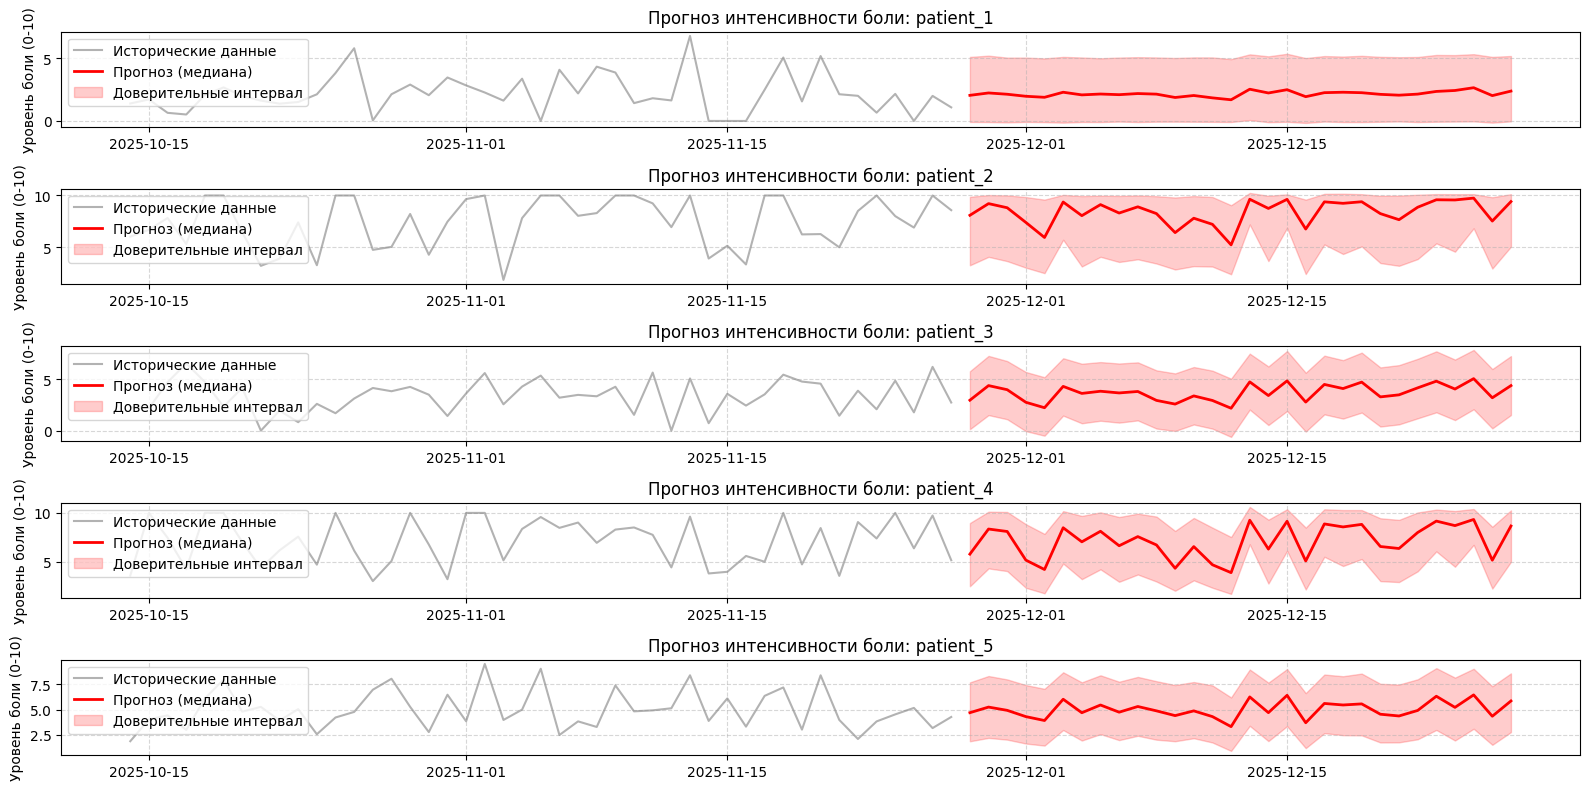

In [6]:
plt.figure(figsize=(16, 8))
for i, p_id in enumerate(patients_list):
    plt.subplot(len(patients_list), 1, i+1)

    # Исторические данные (последние 45 дней для наглядности)
    hist_sub = context_df[context_df["id"] == p_id].tail(45)
    plt.plot(hist_sub["timestamp"], hist_sub["pain_level"], label="Исторические данные", color="gray", alpha=0.6)

    # Прогноз
    pred_sub = pred_df[pred_df["id"] == p_id]
    plt.plot(pred_sub["timestamp"], pred_sub["0.5"], label="Прогноз (медиана)", color="red", lw=2)
    plt.fill_between(
        pred_sub["timestamp"],
        pred_sub["0.05"],
        pred_sub["0.95"],
        color="red", alpha=0.2, label="Доверительные интервал"
    )

    plt.title(f"Прогноз интенсивности боли: {p_id}")
    plt.ylabel("Уровень боли (0-10)")
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Заключение

Проект демонстрирует техническую реализуемость создания персональных систем раннего предупреждения. Использование экзогенных факторов, таких как солнечная активность, в связке с прогнозированием позволяет заблаговременно выявлять неблагоприятные периоды для метеозависимых людей.

Дальнейшие шаги: Для повышения точности рекомендуется заменить синтетические данные на реальные дневники испытуемых и сопоставить их с архивными данными о солнечной активности различных космических агентств.